In [259]:
import os
import urllib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/pcm-dpc/COVID-19"
COVID_PATH = os.path.join("datasets", "covid")
COVID__REGIONI_URL = DOWNLOAD_ROOT + "/master/dati-regioni/dpc-covid19-ita-regioni.csv"

def fetch_dati_regione(regioni_url=COVID__REGIONI_URL, regioni_path=COVID_PATH):
    os.makedirs(regioni_path, exist_ok=True)
    path=os.path.join(regioni_path, "regioni.csv")
    urllib.request.urlretrieve(regioni_url, path)
    
def load_dati_regione(regioni_path=COVID_PATH):
    csv_path=os.path.join(regioni_path, "regioni.csv")
    return pd.read_csv(csv_path)

# Data Gathering

In [260]:
fetch_dati_regione()
regioni=load_dati_regione()
regioni.head()

,data,stato,codice_regione,denominazione_regione,lat,long,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_attualmente_positivi,nuovi_attualmente_positivi,dimessi_guariti,deceduti,totale_casi,tamponi
0,2020-02-24 18:00:00,ITA,13,Abruzzo,42.351222,13.398438,0,0,0,0,0,0,0,0,0,5
1,2020-02-24 18:00:00,ITA,17,Basilicata,40.639471,15.805148,0,0,0,0,0,0,0,0,0,0
2,2020-02-24 18:00:00,ITA,4,P.A. Bolzano,46.499335,11.356624,0,0,0,0,0,0,0,0,0,1
3,2020-02-24 18:00:00,ITA,18,Calabria,38.905976,16.594402,0,0,0,0,0,0,0,0,0,1
4,2020-02-24 18:00:00,ITA,15,Campania,40.839566,14.250850,0,0,0,0,0,0,0,0,0,10


Here we can run a first-look analysis of the data we have in hand

In [261]:
regioni.describe()

,codice_regione,lat,long,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_attualmente_positivi,nuovi_attualmente_positivi,dimessi_guariti,deceduti,totale_casi,tamponi
count,588.000000,588.000000,588.000000,588.000000,588.000000,588.000000,588.000000,588.000000,588.000000,588.000000,588.000000,588.000000,588.000000
mean,10.190476,43.046293,12.225955,289.806122,48.772109,338.579932,276.840136,615.418367,79.316327,76.722789,58.064626,750.205782,3858.069728
std,5.799998,2.490900,2.661212,988.666023,135.735296,1122.451889,790.734604,1871.041502,201.632271,464.180085,283.325697,2581.655716,9087.057712
min,1.000000,38.115697,7.320149,0.000000,0.000000,0.000000,0.000000,0.000000,-63.000000,0.000000,0.000000,0.000000,0.000000
25%,5.000000,41.125596,11.121231,2.000000,0.000000,2.000000,2.000000,5.000000,1.000000,0.000000,0.000000,6.000000,117.500000
50%,10.000000,43.616760,12.388247,19.000000,5.000000,24.500000,31.500000,58.000000,14.000000,0.000000,1.000000,61.000000,611.500000
75%,15.000000,45.434905,13.768136,128.000000,31.250000,163.000000,194.750000,379.250000,65.500000,6.250000,12.000000,400.750000,3084.000000
max,20.000000,46.499335,16.867367,9439.000000,1142.000000,10581.000000,8019.000000,17885.000000,1950.000000,5865.000000,3456.000000,27206.000000,70598.000000


# Data Cleaning

At first sight it is easy to notice that some instances are redundant.

here we change the data instance into an easier one, wiht no time or year. 

In [262]:
day=regioni.data.copy()
import numpy as np
day=np.array(day)
for i in range(len(day)):
    day[i]=day[i][5:10]
day=pd.Series(day)
regioni.insert(0,column='day', value=day)

then we drop the 'data' & 'stato' column which are now useless

In [263]:
regioni=regioni.drop(['data','stato'],axis=1)

now we try to create a dataframe/dictionary which combines values of codice_regione with values of denominazione_regione

we know there are 21 regions so it is enough to access the data frame up to the 20th row. 

In [264]:
def combine_to_dict(df,upto,f1,f2):
    d12={}
    d21={}
    for i in range(upto):
        one=df.at[i,f1]
        two=df.at[i,f2]
        d12[one]=two
        d21[two]=one
    return d12,d21
d_num_as_key,d_reg_as_key=combine_to_dict(regioni,20,f1='codice_regione',f2='denominazione_regione')

now we will shorten the dataframe so that we store in another dataframe the longitude and latitude coordinates which do not change at all

In [265]:
def combine_to_datfr(df,row,col,upto):
    ind=[row[i] for i in range(upto)]
    dt=[]
    for i in range(upto):
        d=[]
        for feat in col:
            el=df.at[i,feat]
            d.append(el)
        dt.append(d)
    ret=pd.DataFrame(data=dt,index=ind,columns=col)
    return ret

new=combine_to_datfr(regioni,regioni.denominazione_regione,['lat','long'],20)    
            

# Analysis

as we can see, we have each day a number of measurements for 21 regions (numbered from 1 to 20)

we can simply extract the number of observations of the civil protection by dividing the shape of the dataframe by 21

In [266]:
n_obs=int(regioni.shape[0]/21)
n_reg=21

This is a function that returns the dataframe of a specific region. 

In [267]:
def get_regione(df,name,period):
    n_obs=int(regioni.shape[0]/period) #number of days of the event observed
    #the period argument is the number of regions in this case, since each day each region is recorded

    for i in range(period):
        if df.at[i,'denominazione_regione']==name:    #we extract the position of the region we want to get
            start=i
            break
    d=regioni[start::period]                          #we extract all the information of it
    d=d.drop(['denominazione_regione','lat','long','codice_regione'],axis=1)   #drop the irrelevant ones
    ind={}
    a=np.arange(1,n_obs+1)                            #index to insert in the new dataframe
    b=np.arange(start,regioni.shape[0],step=period)   #old dataframe position
    for i in range(len(b)):
        ind[b[i]]=a[i]                                #dictionare to translate the two
    d=d.rename(index=ind)                             #now the index of the region dataframe goes from one to n_obs
    return d
Lom=get_regione(regioni,'Lombardia',21)
Ven=get_regione(regioni,'Veneto',21)

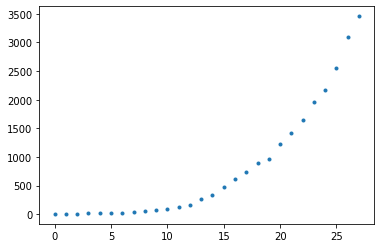